## Using quilt

check to include the path to quilt in your PYTHONPATH

In [1]:
%load_ext autoreload
%autoreload 2
!export PYTHONPATH=$(pwd):$PYTHONPATH
!echo $PYTHONPATH
!which python
%load_ext wurlitzer
%matplotlib ipympl

/home/dianloo/Desktop/tesi/quilt
/home/dianloo/Desktop/tesi/quilt/venv/bin/python


### The example network
In this example two dummy populations of AdEx neurons have excitatory connections with a delay narrowly peaked at 25 ms. 

Almost instantaneous (0.5 ms) self-inhibitory synapses are also present.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from rich import print

with open("tests/spiking_2.yaml", "r") as network_file:
    net_params = yaml.safe_load(network_file)
    print(net_params)

{
    'populations': [
        {'name': 'Albert', 'size': 1000, 'neuron_model': 'dummy_aeif'},
        {'name': 'MonaLisa', 'size': 1000, 'neuron_model': 'dummy_aeif'},
        {'name': 'Francis', 'size': 1000, 'neuron_model': 'dummy_aqif'}
    ],
    'projections': [
        {
            'name': 'A->M',
            'efferent': 'Albert',
            'afferent': 'MonaLisa',
            'features': {'exc_fraction': 0.1, 'max_exc': 0.14, 'min_delay': 20, 'max_delay': 25.1}
        },
        {
            'name': 'A->A',
            'efferent': 'Albert',
            'afferent': 'Albert',
            'features': {
                'inh_fraction': 0.05,
                'max_inh': 0.05,
                'min_delay': 0.1,
                'exc_fraction': 0.0,
                'max_delay': 0.5
            }
        },
        {
            'name': 'M->A',
            'efferent': 'MonaLisa',
            'afferent': 'Albert',
            'features': {'exc_fraction': 0.05, 'max_exc': 0.14, 'min_delay': 20.0, 'max_delay': 25.1}
        },
        {
            'name': 'M->M',
            'efferent': 'MonaLisa',
            'afferent': 'MonaLisa',
            'features': {'inh_fraction': 0.05, 'max_inh': 0.05, 'exc_fraction': 0.0, 'max_delay': 0.5}
        },
        {
            'name': 'A->F',
            'efferent': 'Albert',
            'afferent': 'Francis',
            'features': {'exc_fraction': 0.1, 'max_exc': 0.5, 'max_delay': 0.1, 'min_delay': 0.1}
        },
        {
            'name': 'F->M',
            'efferent': 'Francis',
            'afferent': 'MonaLisa',
            'features': {'inh_fraction': 0.1, 'max_inh': 0.1, 'max_delay': 2, 'min_delay': 0.2}
        }
    ]
}

## Loading the neuron model catalogue
Neuron models are stored in .yaml files called catalogues

In [3]:
from quilt.builder import NeuronCatalogue
neuron_catalogue = NeuronCatalogue.from_yaml("tests/test_params.yaml")

Loaded model for neuron 'dummy_aqif'
Loaded model for neuron 'dummy_aeif'
Loaded model for neuron 'dummy_izhikevich'


## Loading the network
Networks are stored in .yaml files.

In [4]:
from quilt.builder import SpikingNetwork

spikenet = SpikingNetwork.from_yaml("tests/spiking_2.yaml", neuron_catalogue)

Building population 0 took 0 ms    (0.266 us/neur)
Population 0 infos:
	N:1000
	params:
		C_m	40
		Delta	2
		E_exc	0
		E_inh	-65
		E_reset	-55
		E_rest	-70
		E_thr	0
		I_ext	0
		I_osc	0
		ada_a	0
		ada_b	5
		ada_tau_w	100
		exp_threshold	-40
		neuron_type	3
		omega_I	0
		tau_e	10
		tau_i	5.5
		tau_m	200
		tau_refrac	0
Building population 1 took 0 ms    (0.113 us/neur)
Population 1 infos:
	N:1000
	params:
		C_m	40
		Delta	2
		E_exc	0
		E_inh	-65
		E_reset	-55
		E_rest	-70
		E_thr	0
		I_ext	0
		I_osc	0
		ada_a	0
		ada_b	5
		ada_tau_w	100
		exp_threshold	-40
		neuron_type	3
		omega_I	0
		tau_e	10
		tau_i	5.5
		tau_m	200
		tau_refrac	0
Building population 2 took 0 ms    (0.14 us/neur)
Population 2 infos:
	N:1000
	params:
		C_m	15.2
		E_exc	0
		E_inh	-74
		E_reset	-60
		E_rest	-80
		E_thr	-29.7
		I_e	0
		I_ext	0
		I_osc	0
		ada_a	-20
		ada_b	91
		ada_tau_w	100
		k	1
		neuron_type	1
		omega_I	0
		tau_e	12
		tau_i	10
		tau_m	10
		tau_refrac	0
Generating weights and delays took 0.030 seconds
M

### Adding monitors
Not all variables are saved during evolution because variable monitors are both time and memory consuming.

In [5]:
spikenet.populations["Albert"].monitorize_spikes()
# spikenet.populations["Albert"].monitorize_states()

spikenet.populations["MonaLisa"].monitorize_spikes()
spikenet.populations["Francis"].monitorize_spikes()

# spikenet.populations["MonaLisa"].monitorize_states()

### Adding an external stimulus

In [6]:
# Adds a constant current to population Albert of 500pA from t=0ms to t=10ms
spikenet.populations["Albert"].add_injector(300.0, 0, 10)

## Running

In [7]:
spikenet.run(dt=0.1, time=500)

Minimum synaptic delay is 0.1
Running network consisting of 3000 neurons for 5000 timesteps

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Simulation took 4 s	(0.9642 ms/step)
	Gathering time avg: 0.007 us/step
	Inject time avg: 0.0004 us/step


## Retrieving data: spikes
For now just spikes-for-timesteps are saved, thus without caring about which neuron fired.

In [8]:
albert_data = spikenet.populations['Albert'].get_data()
monalisa_data = spikenet.populations['MonaLisa'].get_data()
francis_data = spikenet.populations['Francis'].get_data()

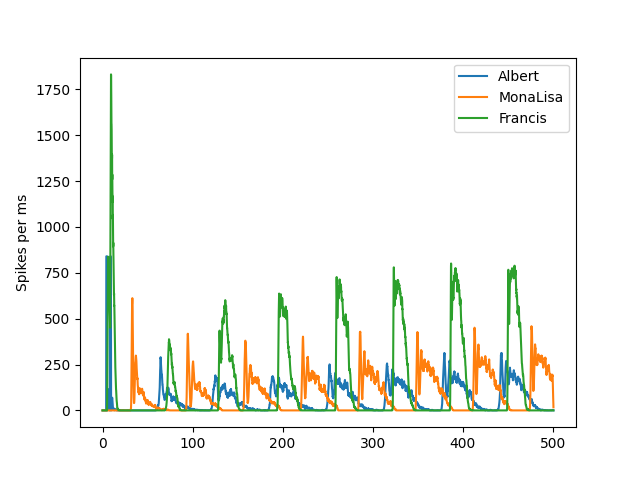

In [9]:
N = 10

plt.plot(np.arange(len(albert_data['spikes']) + N-1 )*0.1, 
         np.convolve(albert_data['spikes'], np.ones(N)), 
         label="Albert")

plt.plot(np.arange(len(monalisa_data['spikes']) + N-1 )*0.1, 
         np.convolve(monalisa_data['spikes'], np.ones(N)), 
         label="MonaLisa")

plt.plot(np.arange(len(francis_data['spikes']) + N-1 )*0.1, 
         np.convolve(francis_data['spikes'], np.ones(N)), 
         label="Francis")


plt.ylabel("Spikes per ms");
plt.legend()

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ... 20 19 17]
 [ 0  0  0 ...  0  0  0]]


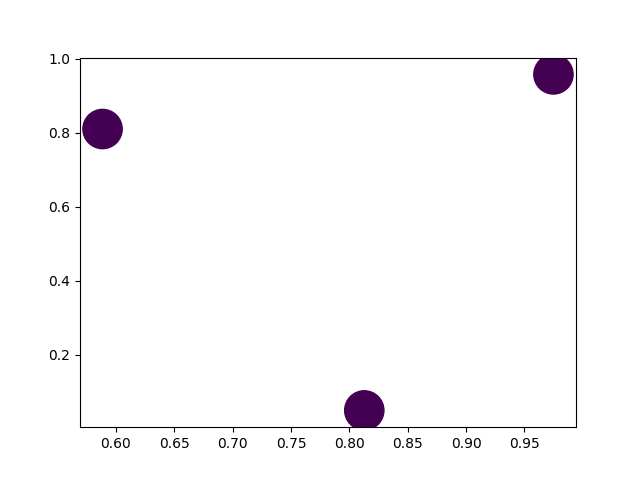

In [25]:
from quilt import view
u = view.animate_spiking(spikenet)

## Retrieving data: states

The state of a neuron consist of its membrane potential, synaptic conductances and (for adaptive neurons) the recovery variable.

In [10]:
states = np.array(albert_data['states'])

KeyError: 'states'

In [ ]:
for i in range(5):
    plt.plot(states[:, i, 0], color="k", alpha=0.5)
    plt.title("V of Albert's neurons")

In [ ]:
for i in range(200):
    plt.plot(states[:, i, 1], alpha=0.01, color="k")
    plt.title("Albert's gsyn_exc")

In [ ]:
for i in range(200):
    plt.plot(states[:, i, 2], alpha=0.01, color="k")
    plt.title("Albert's gsyn_inh")

In [ ]:
for i in range(100):
    plt.plot(states[:, i, 3], color="k", alpha=0.05)
    plt.title("Albert's recovery")

In [ ]:
states = np.array(spikenet.populations['MonaLisa'].get_data()['states'])

for idx, feat in enumerate(["V", "gsyne", "gsyni", "u"]):
    plt.plot(states[:, 0, idx], label=feat)
plt.title("MonaLisa (Neuron 0)")
plt.legend()


plt.show()